In [1]:
# if neeeded install first tensorflow
#pip install tensorflow

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# **Deep network to fit option prices**

We introduce a deep network to fit options prices under Black-Scholes model.



## Generate the dataset

The dataset contains a list (pandas dataframe or numpy array) with columns: stock price,strike, time to maturity, dividend rate, interest rate, volatility.

Take variables:

- stock price uniform [50,150] or log-normal with mean 100 and volatility enough to have prices in range +-20% of 100
- strike the same
- time to maturity uniform : from 5/255 (one week) to 2. (in years)
- dividend rate : uniform 0 to 10%
- interest rate : uniform 0 to 10%
- volatility : uniform 0.1% to 50%

All variables are sampled simultaneously (not as tensor product). Sample M=100'000 of them.

In [ ]:
# generate dataset of input variables : replace None with your code
M=100_000

import pandas as pd
df = pd.DataFrame({'Price':np.random.uniform(50,100,M),
                   'Strike':np.random.uniform(50,100,M),
                   'Rate':np.random.uniform(0.0,0.1,M),
                   'TimeToMaturity':np.random.uniform(5./255.,2.,M),
                   'Volatility':np.random.uniform(0.1/100.,0.5,M),
                   'DividendRate':np.random.uniform(0.0,0.1,M)})
df.head()

### Recall Black-Scholes call option formula
Load the function and make a new column in the dataset
called 'call_price'. Backup the dataset with pickle.


In [4]:
import numpy as np
from scipy.stats import norm

def blsprice(Price,Strike,Rate,TimeToMaturity,Volatility,DividendRate=0):
    """input:
       S:Price - Current price of the underlying asset.

       Strike:Strike - Strike (i.e., exercise) price of the option.

       Rate: Rate - Annualized continuously compounded risk-free rate of return over
         the life of the option, expressed as a positive decimal number.

       TimeToMaturity:Time - Time to expiration of the option, expressed in years.

      Volatility: volatility
      DividendRate = continuous dividend rate
    """

    d1 = np.log(Price/Strike)+(Rate-DividendRate + Volatility**2/2.0)*TimeToMaturity;
    d1 = d1/(Volatility* np.sqrt(TimeToMaturity+1.e-10))
    d2 = d1-(Volatility*np.sqrt(TimeToMaturity+1.e-10))

    call = Price * np.exp(-DividendRate*TimeToMaturity) * norm.cdf(d1)-Strike* np.exp(-Rate*TimeToMaturity) * norm.cdf(d2)
    put  = Strike* np.exp(-Rate*TimeToMaturity) * norm.cdf(-d2)-Price* np.exp(-DividendRate*TimeToMaturity) * norm.cdf(-d1)
    return call,put


In [5]:
df['call_price'] = blsprice(df['Price'],df['Strike'],df['Rate'],
                            df['TimeToMaturity'],df['Volatility'],
                            df['DividendRate'])[0]
df.to_pickle("option_prices.pkl")
df_copy=df.copy()

In [6]:
df_copy.head()

Price     Strike      Rate  TimeToMaturity  Volatility  DividendRate  \
0  74.702678  73.179324  0.089254        1.635369    0.485613      0.043554   
1  51.126952  93.836196  0.014216        0.500772    0.410146      0.073158   
2  79.565357  75.598025  0.087289        0.809727    0.445513      0.052929   
3  73.722946  80.342856  0.006344        1.103548    0.137653      0.002392   
4  69.643231  67.622451  0.074956        0.781187    0.431052      0.054194   

   call_price  
0   19.538007  
1    0.096978  
2   14.766650  
3    1.975601  
4   11.420017

### Express relative to strike

It is customary to express data in moneyness i.e. divide stock price and call price by the strike. In particular in the log-normal model the option price only depends on the quotient Price/Strike.

In [7]:
## divide by S/K
df_copy["Price"] = df_copy["Price"]/df_copy["Strike"]
df_copy["call_price"] = df_copy["call_price"]/df_copy["Strike"]
df_copy.head()
df_copy.drop(columns = ['Strike'], inplace = True)

In [8]:
df_copy.head(50)

Price      Rate  TimeToMaturity  Volatility  DividendRate    call_price
0   1.020817  0.089254        1.635369    0.485613      0.043554  2.669881e-01
1   0.544853  0.014216        0.500772    0.410146      0.073158  1.033487e-03
2   1.052479  0.087289        0.809727    0.445513      0.052929  1.953312e-01
3   0.917604  0.006344        1.103548    0.137653      0.002392  2.458963e-02
4   1.029883  0.074956        0.781187    0.431052      0.054194  1.688791e-01
5   0.917431  0.040032        1.679295    0.457111      0.077085  1.444066e-01
6   1.068716  0.052535        1.250599    0.443211      0.086451  1.971190e-01
7   1.633638  0.064372        0.780998    0.365117      0.079991  5.954896e-01
8   0.735868  0.083245        1.893283    0.236255      0.057956  2.929560e-02
9   1.047264  0.006180        1.635994    0.178902      0.045380  8.083985e-02
10  0.810614  0.076433        1.440259    0.429926      0.047558  1.074797e-01
11  0.676853  0.026589        0.214975    0.216417      0.085891  5.404353e-07
12  1.366214  0.082622        1.272218    0.352218      0.035410  4.457516e-01
13  1.191730  0.009598        0.640400    0.218303      0.011565  2.049028e-01
14  0.991039  0.078615        1.059452    0.109597      0.027418  6.698960e-02
15  0.617205  0.027846        0.073001    0.215342      0.023651  3.067387e-19
16  0.929447  0.025613        0.997141    0.464817      0.043464  1.319512e-01
17  1.413191  0.010567        1.255283    0.068967      0.028267  3.771031e-01
18  0.822466  0.014313        1.331237    0.450879      0.011809  1.100730e-01
19  0.974151  0.088571        1.429286    0.400132      0.036295  1.934672e-01
20  0.646059  0.024545        1.630114    0.246361      0.027411  8.736488e-03
21  0.706138  0.029796        0.402998    0.370064      0.040281  5.687995e-03
22  1.332972  0.006152        1.234265    0.116470      0.068418  2.356967e-01
23  0.976108  0.045433        0.209427    0.315955      0.016844  4.808952e-02
24  0.782728  0.077319        0.661939    0.288696      0.071924  1.555760e-02
25  0.702086  0.072606        1.137689    0.162976      0.019752  2.589984e-03
26  1.144971  0.012952        0.501748    0.299849      0.085081  1.496310e-01
27  0.932487  0.087649        1.969964    0.427924      0.082759  1.691497e-01
28  0.889672  0.000785        0.846741    0.432916      0.005266  9.867330e-02
29  1.520037  0.039369        0.880363    0.034027      0.069604  4.637554e-01
30  1.552284  0.008497        0.688526    0.372519      0.061697  5.103850e-01
31  1.327741  0.077055        1.823977    0.029139      0.046992  3.497950e-01
32  1.309142  0.030851        1.873132    0.293214      0.084703  2.644889e-01
33  1.229366  0.088821        0.167951    0.310020      0.081359  2.304538e-01
34  0.895085  0.081699        0.527342    0.406930      0.001591  7.992579e-02
35  0.823686  0.095337        1.694707    0.287606      0.080687  6.183874e-02
36  0.751038  0.064735        1.232964    0.393592      0.065009  5.309175e-02
37  0.972833  0.009587        1.112592    0.197133      0.036699  5.492514e-02
38  1.331816  0.066280        0.954377    0.191786      0.008917  3.846376e-01
39  0.854717  0.098562        1.167048    0.288278      0.001984  8.968623e-02
40  1.379511  0.077871        1.610772    0.308862      0.057533  4.159509e-01
41  0.521087  0.061914        0.307619    0.145968      0.051801  3.890930e-18
42  0.757643  0.070342        1.520939    0.056071      0.015943  4.047306e-05
43  1.066228  0.030880        1.419101    0.360600      0.011328  2.204787e-01
44  0.962125  0.040533        1.559954    0.332186      0.089296  1.005099e-01
45  0.682314  0.057286        0.183738    0.068388      0.053883  8.690868e-42
46  0.974939  0.048614        1.640771    0.131798      0.074745  3.443388e-02
47  1.014613  0.017952        1.596238    0.450198      0.014767  2.294606e-01
48  1.394338  0.098812        0.667706    0.235914      0.019557  4.419530e-01
49  1.117943  0.037843        0.923024    0.437189      0

### Construct the dataset

In [9]:
X=df_copy[['Price','Rate','TimeToMaturity','Volatility','DividendRate']]
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Price           100000 non-null  float64
 1   Rate            100000 non-null  float64
 2   TimeToMaturity  100000 non-null  float64
 3   Volatility      100000 non-null  float64
 4   DividendRate    100000 non-null  float64
dtypes: float64(5)
memory usage: 3.8 MB


In [10]:
 y = df_copy['call_price'] #target variable

In [11]:
# split a dataset into train and test sets
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 1)

In [12]:
X_train,y_train,X_test,y_test

(          Price      Rate  TimeToMaturity  Volatility  DividendRate
 78689  1.236304  0.075225        1.358254    0.078859      0.097649
 76423  1.200502  0.090692        0.916368    0.408080      0.074204
 86945  0.764008  0.043549        0.475301    0.342809      0.038900
 57427  1.261401  0.053397        1.052272    0.080898      0.005201
 34616  0.780385  0.055259        1.939798    0.017098      0.007640
 ...         ...       ...             ...         ...           ...
 50057  1.185624  0.032587        0.417540    0.176293      0.096702
 98047  0.958445  0.034316        0.782995    0.497134      0.066850
 5192   1.072501  0.075670        0.390256    0.277414      0.016809
 77708  1.354072  0.008220        0.136237    0.030052      0.096697
 98539  0.651661  0.022863        0.304399    0.091618      0.070476
 
 [80000 rows x 5 columns],
 78689    1.806877e-01
 76423    2.782871e-01
 86945    1.304586e-02
 57427    3.091626e-01
 34616    9.290866e-14
              ...     
 5005

In [13]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(80000, 5) (20000, 5) (80000,) (20000,)


In [14]:
### Start the deep learning part

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU,Input
from keras import backend

In [16]:
#sometimes exp_activation can be used
def exp_activation(x):
    return backend.exp(x)

## Define the network

Use fully connected nodes with ReLU activation. For the loss function use 'mse'; use optimizer 'Adam' or 'RMSprop'. Also define a custom metric to output the relative error.

In [72]:
model = Sequential()
model.add(Input(shape=(5,)))
#model.add(Dense(100, activation='relu', input_shape=(5,)))
for jj in range(4):
    model.add(Dense(250, activation='relu'))
    model.add(Dropout(0.25))

model.add(Dense(1, activation='relu'))

# Define the relative error metric
def relative_error_metric(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (1.e-6+tf.abs(y_true)) ))

model.compile(loss='mse',optimizer='rmsprop', metrics=[relative_error_metric])
#model.compile(loss=relative_error_metric,optimizer='rmsprop', metrics=[relative_error_metric])

#model.compile(optimizer='rmsprop',loss='mse',
#  metrics=[tf.keras.losses.MeanAbsoluteError()])


In [73]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 250)               1500      
                                                                 
 dropout_13 (Dropout)        (None, 250)               0         
                                                                 
 dense_31 (Dense)            (None, 250)               62750     
                                                                 
 dropout_14 (Dropout)        (None, 250)               0         
                                                                 
 dense_32 (Dense)            (None, 250)               62750     
                                                                 
 dropout_15 (Dropout)        (None, 250)               0         
                                                                 
 dense_33 (Dense)            (None, 250)              

## Train the model

In [74]:
history = model.fit(X_train, y_train, batch_size=256, epochs=20,validation_split=0.1, verbose=2)

Epoch 1/20
282/282 - 3s - loss: 0.0112 - relative_error_metric: 2422.2849 - val_loss: 0.0042 - val_relative_error_metric: 326.1038 - 3s/epoch - 10ms/step
Epoch 2/20
282/282 - 1s - loss: 0.0042 - relative_error_metric: 705.0799 - val_loss: 0.0121 - val_relative_error_metric: 8.4461 - 1s/epoch - 5ms/step
Epoch 3/20
282/282 - 1s - loss: 0.0030 - relative_error_metric: 624.1748 - val_loss: 0.0096 - val_relative_error_metric: 2.7889 - 1s/epoch - 4ms/step
Epoch 4/20
282/282 - 1s - loss: 0.0024 - relative_error_metric: 626.0630 - val_loss: 0.0167 - val_relative_error_metric: 0.6593 - 1s/epoch - 4ms/step
Epoch 5/20
282/282 - 1s - loss: 0.0021 - relative_error_metric: 538.0959 - val_loss: 0.0098 - val_relative_error_metric: 0.9990 - 960ms/epoch - 3ms/step
Epoch 6/20
282/282 - 1s - loss: 0.0019 - relative_error_metric: 448.6562 - val_loss: 0.0082 - val_relative_error_metric: 0.4818 - 940ms/epoch - 3ms/step
Epoch 7/20
282/282 - 1s - loss: 0.0017 - relative_error_metric: 373.4045 - val_loss: 0.006

## Plot the results

In [75]:
history.history.keys()

dict_keys(['loss', 'relative_error_metric', 'val_loss', 'val_relative_error_metric'])

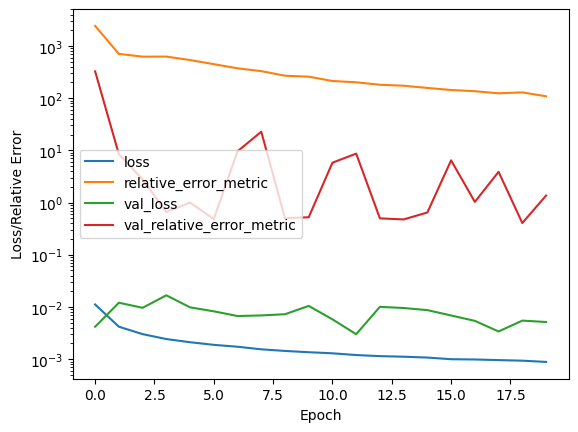

In [76]:
# Plot the training history including the custom metric (relative error)
import matplotlib.pyplot as plt

for key_label in history.history.keys():
  plt.semilogy(history.history[key_label], label=key_label)
plt.xlabel('Epoch')
plt.ylabel('Loss/Relative Error')
plt.legend()
plt.show()

## Exploit results

- compute the call given by the network
- can also compute de greeks (differentiating the tensorflow model)


In [79]:
model(np.array([1.,0.05,1.,0.2,0.05]).reshape(1,5)) #input order : ['Price','Rate','TimeToMaturity','Volatility','DividendRate']

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.078894]], dtype=float32)>

In [80]:
blsprice(1.,1.,1.,0.1,0.1,0.2)[0]

0.0754156466308139

In [78]:
# conclusion: fitting is ok but can be improved ...